In [1]:
import torch
import numpy as np
from CIMS.src._CIM import CIM
from CIMS.src._dataset import MultiChannelDataset
from CIMS.src import celltype_colors, meta_celltype_colors, meta_map
from CIMS.src.utils.visualize import compute_umap_embedding, plot_umap_embedding
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

/home/simon_g/anaconda3/envs/MIDL26/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_features(dataloader, model, device, N=10_000):
    model.eval()
    feats = []
    labels = []
    n_collected = 0

    with torch.no_grad():
        for batch in tqdm(dataloader):
            imgs = batch["img"].permute(0, 3, 1, 2).to(device)
            out = model(imgs)
            out = out.squeeze().detach().cpu().numpy()
            feats.append(out)
            labels.extend(batch["annotation"])

            n_collected += out.shape[0]
            if n_collected >= N:
                break

    X = np.concatenate(feats, axis=0)[:N]   # shape (N, D)
    y = np.array(labels[:N])                # shape (N,)
    return X, y

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

channels = 18

markers_to_use = None
if channels == 18:
    markers_to_use = ['DAPI-01','CD11b','CD11c','CD15','CD163','CD20','CD206','CD30','CD31','CD4','CD56','CD68','CD7','CD8','Cytokeritin','FoxP3','MCT','Podoplanin']

h5_file = './dataset/cHL.h5'

model = CIM(in_channels=channels, width_per_channel=4, layers=[1], late_fusion=False)
model.load_state_dict(torch.load(f'./weights/CIMS_{channels}.pth'))
model = model.to(device)
model.eval();

n_parameters = sum([m.numel() for m in model.parameters() if m.requires_grad])
print(f'Model has {n_parameters} trainable parameters.')

Model has 2034 trainable parameters.


In [4]:
dataset = MultiChannelDataset(
    h5_file,
    markers_to_use=markers_to_use,
    patch_size=24,
    shuffle=False,
    image_key='NORMED_IMAGES',
    in_memory=False,
    used_split='all',
    mask_image=True,
    classes_to_ignore=['Seg Artifact']
)

dataloader = DataLoader(dataset, batch_size=32, num_workers=8)

print('\n', dataset)

Removing 1431 instances of class:"Seg Artifact"
Dataset contains annotations
Dataset contains 145161 cells.
All Markers: ['PD-1' 'CD45RA' 'CCR6' 'Granzyme B' 'CD163' 'T-bet' 'CD4' 'EGFR' 'TCRb'
 'CD20' 'CD45RO' 'MMP-9' 'CD57' 'MUC-1' 'CD162' 'CD11b' 'CD25'
 'Cytokeritin' 'CD46' 'CD56' 'HLA-DR' 'TCR-g-d' 'CD5' 'CD8' 'CD30' 'BCL-2'
 'IDO-1' 'CD2' 'CD11c' 'b-Catenin' 'CD69' 'Collagen 4' 'CD68' 'CD7'
 'LAG-3' 'DAPI-01' 'a-SMA' 'MCT' 'PD-L1' 'Vimentin' 'CD15' 'CD31' 'Tim-3'
 'FoxP3' 'CD16' 'Podoplanin' 'CD206' 'VISA' 'CD44']
Image data has original shape: 8011 x 8085 x 49
Used Markers: ['DAPI-01' 'CD11b' 'CD11c' 'CD15' 'CD163' 'CD20' 'CD206' 'CD30' 'CD31'
 'CD4' 'CD56' 'CD68' 'CD7' 'CD8' 'Cytokeritin' 'FoxP3' 'MCT' 'Podoplanin']
Using all split!

 H5-File: ./dataset/cHL.h5
Using all split

Dataset Summary:
Celltype                      Count     Percent
-----------------------------------------------
CD4                           37480      26.08%
CD8                           17184      11

In [6]:
N = 50_000

results_dict = dict(features=[], annotations=[])
for batch in tqdm(dataloader, total=N//dataloader.batch_size):
    batched_images = batch['img'].permute(0, 3, 1, 2).to(device)
    batch_features = model(batched_images).squeeze().detach().cpu().numpy()
    results_dict['features'].extend(batch_features) 
    results_dict['annotations'].extend(batch['annotation']) 
    
    if len(results_dict['features']) > N:
        break
    
results_df = pd.DataFrame(results_dict)

100%|██████████| 1562/1562 [00:38<00:00, 40.31it/s]


In [7]:
results_df = compute_umap_embedding(results_df, dim=2)

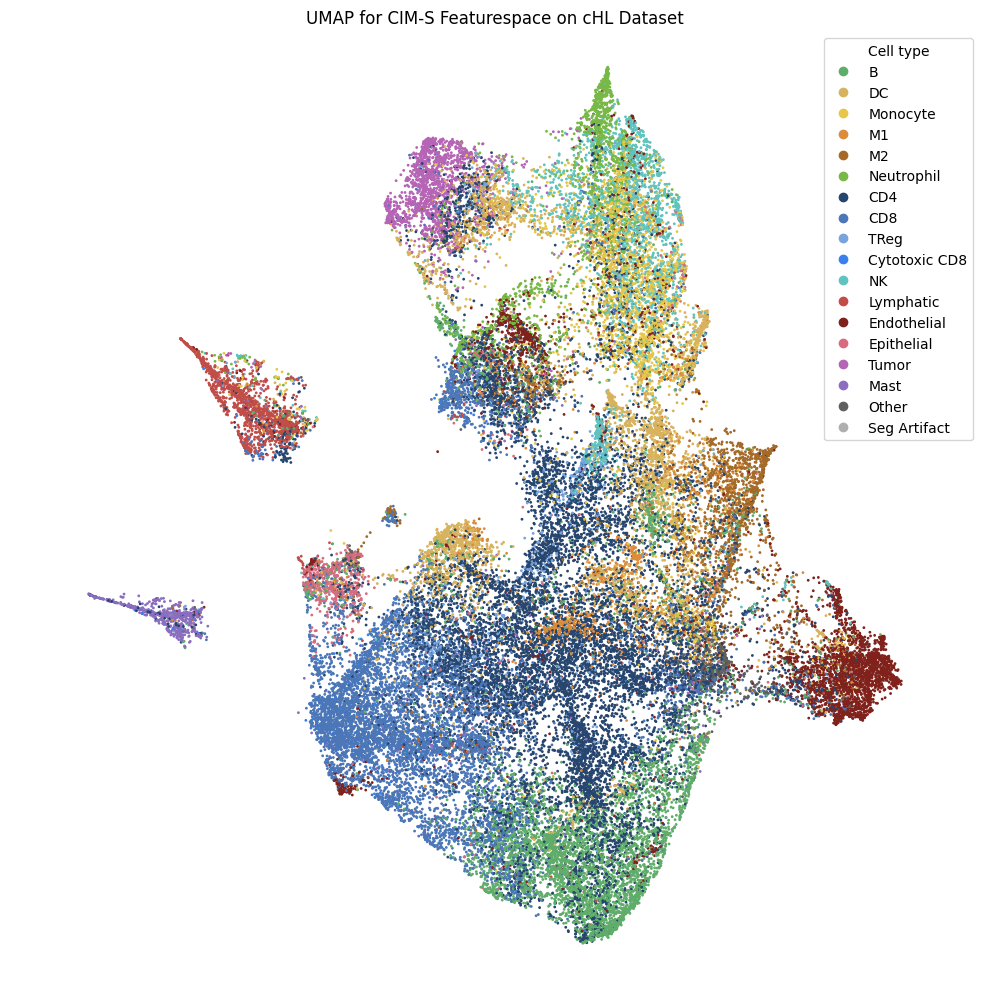

In [8]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(10, 10))

# main scatter plot
plt.scatter(
    results_df.UMAP_X,
    results_df.UMAP_Y,
    s=1,
    c=[celltype_colors[a] for a in results_df.annotations]
)

# build legend handles from your celltype_colors dict
legend_handles = [
    Line2D(
        [], [], 
        marker='o', linestyle='None',
        color=color,
        label=celltype,
        markersize=6
    )
    for celltype, color in celltype_colors.items()
]

plt.legend(
    handles=legend_handles,
    title="Cell type",
    loc="upper right",
    frameon=True
)

plt.title('UMAP for CIM-S Featurespace on cHL Dataset')
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

# --- 1. Build datasets & dataloaders ---

common_ds_kwargs = dict(
    h5_file_path=h5_file,
    markers_to_use=markers_to_use,
    patch_size=24,
    shuffle=False,
    image_key="NORMED_IMAGES",
    in_memory=True,
    mask_image=True,
    classes_to_ignore=["Seg Artifact"],
)

train_dataset = MultiChannelDataset(**common_ds_kwargs, used_split="train")
test_dataset  = MultiChannelDataset(**common_ds_kwargs, used_split="test")

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8)
test_loader  = DataLoader(test_dataset,  batch_size=32, num_workers=8)

# --- 3. Actually extract features for train and test ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

X_train, y_train = extract_features(train_loader, model, device, N=100_000)
X_test,  y_test  = extract_features(test_loader,  model, device, N=100_000)

Removing 1431 instances of class:"Seg Artifact"
Dataset contains annotations
Dataset contains 145161 cells.
Start loading images to memory
Finished loading images to memory
All Markers: ['PD-1' 'CD45RA' 'CCR6' 'Granzyme B' 'CD163' 'T-bet' 'CD4' 'EGFR' 'TCRb'
 'CD20' 'CD45RO' 'MMP-9' 'CD57' 'MUC-1' 'CD162' 'CD11b' 'CD25'
 'Cytokeritin' 'CD46' 'CD56' 'HLA-DR' 'TCR-g-d' 'CD5' 'CD8' 'CD30' 'BCL-2'
 'IDO-1' 'CD2' 'CD11c' 'b-Catenin' 'CD69' 'Collagen 4' 'CD68' 'CD7'
 'LAG-3' 'DAPI-01' 'a-SMA' 'MCT' 'PD-L1' 'Vimentin' 'CD15' 'CD31' 'Tim-3'
 'FoxP3' 'CD16' 'Podoplanin' 'CD206' 'VISA' 'CD44']
Image data has original shape: 8011 x 8085 x 49
Used Markers: ['DAPI-01' 'CD11b' 'CD11c' 'CD15' 'CD163' 'CD20' 'CD206' 'CD30' 'CD31'
 'CD4' 'CD56' 'CD68' 'CD7' 'CD8' 'Cytokeritin' 'FoxP3' 'MCT' 'Podoplanin']
100611 14373 28746
Using train split!
Removing 1431 instances of class:"Seg Artifact"
Dataset contains annotations
Dataset contains 145161 cells.
Start loading images to memory
Finished loading images 

100%|██████████| 899/899 [00:06<00:00, 140.84it/s]


In [10]:
# --- 4. Train linear probe (logistic regression) ---

probe = LogisticRegression(
    solver="lbfgs",
    penalty="l2",
    max_iter=5000,
    C=10
)

probe.fit(X_train, y_train)

print(f"Train accuracy:", probe.score(X_train, y_train))
print(f"Test accuracy:",  probe.score(X_test,  y_test))

Train accuracy: 0.75299
Test accuracy: 0.7537396507340152
